In [1]:
# Making the Extinction Law Plot 
# Figure 7 (as of now) 

In [2]:
import numpy as np 

In [3]:
# Slope Data 
calculated_slopes = {
    'NRCB1': {
        'F115W-F212N_F115W': (1.3783934884977551, 0.028921415345827043),
        'F115W-F323N_F115W': (1.18925071763471, 0.11319023750454783),
        'F115W-F405N_F115W': (1.1256001978455172, 0.02107545055589014)},
    'NRCB2': {
        'F115W-F212N_F115W': (1.433619116296105, 0.014707871064684802),
        'F115W-F323N_F115W': (1.252205350310538, 0.05031708658137358),
        'F115W-F405N_F115W': (1.133458286910668, 0.022466723435415285)},
    'NRCB3': {
        'F115W-F212N_F115W': (1.37665777135227, 0.015269454835811783),
        'F115W-F323N_F115W': (1.2059653704236974, 0.023703574159578654),
        'F115W-F405N_F115W': (1.1167554990829216, 0.010318655753549904)},
    'NRCB4': {
        'F115W-F212N_F115W': (1.4452866016546932, 0.013893774181367202),
        'F115W-F323N_F115W': (1.2459626347670318, 0.04850456849373304),
        'F115W-F405N_F115W': (1.1232545226672153, 0.008997371775779764)}}

fritz_slopes = {
    "F115W-F212N_F115W": 1.3963332346626527, 
    "F115W-F323N_F115W": 1.2228382161183373, 
    "F115W_F405N_F115W": 1.1194436688421505}

# roughly 
filter_wavelengths = {
    "F115W": 1.15, 
    "F212N": 2.12, 
    "F323N": 3.23, 
    "F405N": 4.05
}

In [4]:
# Helper Functions
def extinction_ratios_from_slopes(slope_dict):
    """
    Convert slopes  A_<filtery> / E(F115W – <filter2>)  to A_<filtery> / A_F115W
    Propagates 1sigma errors. 
    """ 
    
    out = {}
    for key, value in slope_dict.items():
        if value is None:
            continue                        
        R, sR = value                      
        color, fy = key.split('_')
        f1,  f2 = color.split('-')  
        num = f2 
        r = (R-1.0) / R 
        sr = sR / R**2
        
        out[f"A{num}/AF115W"] = (r, sr)
    return out

def relative_to_F212N(out):
    """ 
    Convert extinction ratios A_lambda/AF115W to A_lambda/AF212N,
    with error propagation
    """
    ratios = {
        "AF115W/AF212N": None,
        "AF323N/AF212N": None,
        "AF405N/AF212N": None,
    }

    # AF115W/A212N
    x, dx = out["AF212N/AF115W"]
    val = 1.0 / x
    err = abs(val) * (dx / abs(x))
    ratios["AF115W/AF212N"] = (val, err)

    # AF323N/AF212N
    a, da = out["AF323N/AF115W"]
    b, db = out["AF212N/AF115W"]
    val = a / b
    err = abs(val) * np.sqrt((da / a)**2 + (db / b)**2)
    ratios["AF323N/AF212N"] = (val, err)

    # AF405N/AF212N
    a, da = out["AF405N/AF115W"]
    b, db = out["AF212N/AF115W"]
    val = a / b
    err = abs(val) * np.sqrt((da / a)**2 + (db / b)**2)
    ratios["AF405N/AF212N"] = (val, err)

    return ratios

In [19]:
# Extinction Ratios
extinction_ratios = {
    "NRCB1": None,
    "NRCB2": None, 
    "NRCB3": None, 
    "NRCB4": None,
}

for key in ["NRCB1", "NRCB2", "NRCB3", "NRCB4"]: 
    out = extinction_ratios_from_slopes(calculated_slopes[key])
    extinction_ratios[key] = relative_to_F212N(out)

import pickle 
import os 
from pathlib import Path

extinction_ratios_out = Path(os.getcwd()) / "raw"
extinction_ratios_out.mkdir(exist_ok=True, parents=True) 
extinction_ratios_fname = extinction_ratios_out / "ratios.dev"

with open(extinction_ratios_fname, "wb") as f: 
    pickle.dump(extinction_ratios, f)

In [8]:
# Known GC Laws 
# Using SPISEA (M. W. Hosek et al. (2020)) 
from spisea import reddening

In [9]:
# CCM, Rieke, Nishiyama09, Hosek18, NoguerasLara2020
laws     = [
    reddening.RedLawCardelli(Rv=3.1),
    reddening.RedLawRiekeLebofsky(),
    reddening.RedLawNishiyama09(),
    reddening.RedLawHosek18b(),
    reddening.RedLawNoguerasLara20()
]
methods  = [
    "Cardelli89", 
    "RiekeLebofsky85", 
    "Nishiyama09",
    "Hosek18b", 
    "NoguerasLara20"
]
wavs     = [
    (1, 2.95, 20), 
    (1, 4, 4), 
    (1, 7.9, 6),
    (1, 3.54, 300), 
    (1, 2.2, 6)
]

GC_Laws = {}
for law, name, wav_tuple in zip(laws, methods, wavs):
    fn  = getattr(law, name)               
    wavelength  = np.linspace(*wav_tuple)

    A212N         = fn(wavelength=2.12, AKs=2.5)
    extinction    = fn(wavelength=wavelength, AKs=2.5)  
    GC_Laws[name] = np.vstack([wavelength, extinction / A212N])

In [10]:
# Fritz11 
fritz_law = reddening.RedLawFritz11() 
wavelength, extinction, error = fritz_law._read_Fritz11() 
mask = (wavelength < 19.5) 
wavelength = wavelength[mask] 
extinction = extinction[mask] 

A212N = fritz_law.Fritz11(wavelength=2.12, A_scale_lambda=2.5) 
fritz = np.vstack([wavelength, extinction / A212N]) 

In [11]:
# G23 
from dust_extinction.parameter_averages import G23 
import astropy.units as u 

extmod = G23(Rv=3.1)
x_min, x_max = extmod.x_range

lam_min = (1/x_max)      
lam_max = (1/x_min)         

wave_min_AA = (lam_min * u.um).to(u.AA).value
wave_max_AA = (lam_max * u.um).to(u.AA).value

wavelengths = np.logspace(
    np.log10(wave_min_AA),
    np.log10(wave_max_AA),
    2000
) * u.AA

A_over_AV    = extmod(wavelengths)
A_Ks_over_AV = extmod((2.17 * u.um).to(u.AA))  
A_over_AKs   = A_over_AV / A_Ks_over_AV

mask        = (wavelengths.to(u.um).value > 1) & (wavelengths.to(u.um).value < 19.5)
wavelengths = wavelengths[mask] 
A_over_AKs  = A_over_AKs[mask]

G23 = np.vstack([wavelengths.to(u.um).value, A_over_AKs])

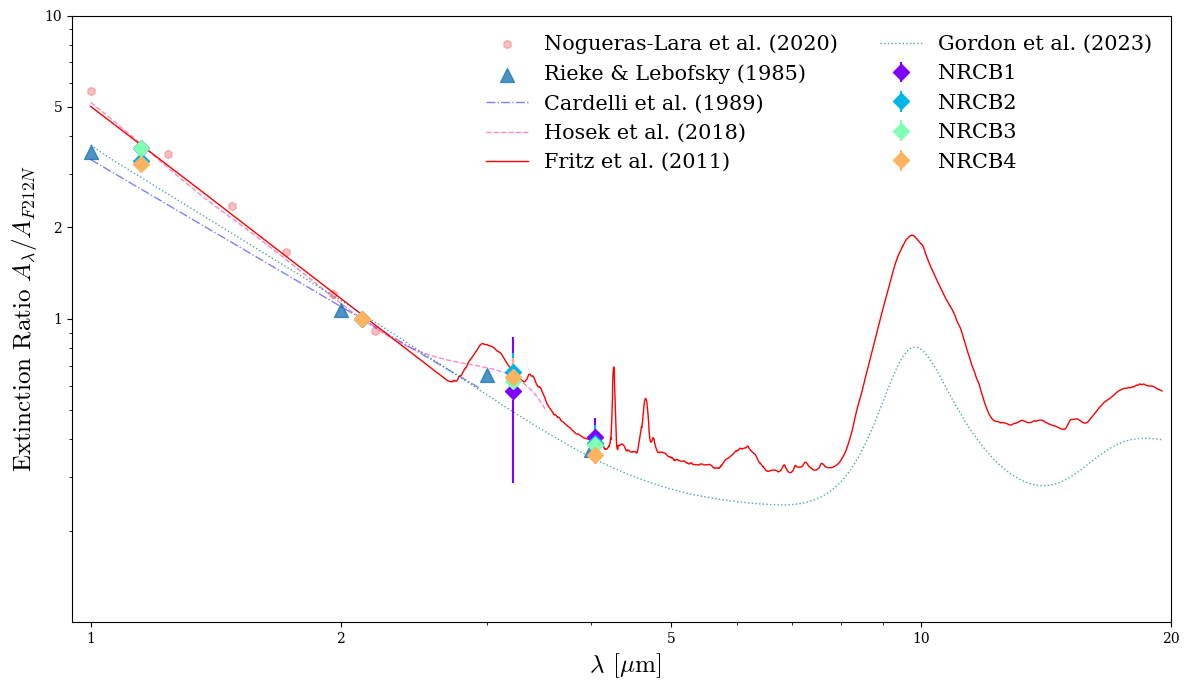

In [15]:
import matplotlib.pyplot as plt 

from cycler import cycler 
from matplotlib import cm 

nice5 = plt.get_cmap("rainbow")(np.linspace(0,1,5))
plt.rcParams["axes.prop_cycle"] = cycler(color=nice5)
plt.rcParams['font.family']      = 'serif'
plt.rcParams['mathtext.fontset'] = 'cm'

figure, axis = plt.subplots(figsize=(12, 7)) 

w_ccm, r_ccm     = GC_Laws["Cardelli89"] 
w_hosek, r_hosek = GC_Laws["Hosek18b"] 
w_rieke, r_rieke = GC_Laws["RiekeLebofsky85"] 
w_nishi, r_nishi = GC_Laws["Nishiyama09"] 
w_nogue, r_nogue = GC_Laws["NoguerasLara20"]
w_fritz, r_fritz = fritz 
w_g23, r_g23     = G23

axis.scatter(
    w_nogue, r_nogue,
    color='lightcoral',         
    marker='h', 
    alpha=0.5,
    label='Nogueras-Lara et al. (2020)'
)
axis.scatter(
    w_rieke, r_rieke,
    marker='^',
    s=100,
    facecolor='tab:blue',
    alpha=0.8,
    label='Rieke & Lebofsky (1985)'
)
axis.plot(
    w_ccm, r_ccm, 
    color='b', 
    linewidth=1,
    linestyle='-.', 
    alpha=0.5, 
    label='Cardelli et al. (1989)'
)
axis.plot(
    w_hosek, r_hosek, 
    color='deeppink', 
    linewidth=1,
    linestyle='--', 
    alpha=0.5, 
    label='Hosek et al. (2018)'
) 
axis.plot(
    w_fritz, r_fritz,
    color='r',         
    linewidth=1,
    linestyle='-',
    alpha=1,
    label='Fritz et al. (2011)'
)
axis.plot(
    w_g23, r_g23, 
    color='teal', 
    linewidth=1,
    linestyle=':', 
    alpha=0.7, 
    label='Gordon et al. (2023)'
)


for region, ratios in extinction_ratios.items(): 
    x = np.array([
        filter_wavelengths['F115W'],
        filter_wavelengths['F212N'],
        filter_wavelengths['F323N'],
        filter_wavelengths['F405N']
    ])
    y = np.array([
        ratios['AF115W/AF212N'][0],
        1.0,
        ratios['AF323N/AF212N'][0],
        ratios['AF405N/AF212N'][0]
    ])
    yerr = np.array([
        ratios['AF115W/AF212N'][1],
        0.0,
        ratios['AF323N/AF212N'][1],
        ratios['AF405N/AF212N'][1]
    ])

    axis.errorbar(
        x, y, yerr=yerr,
        markersize=8, 
        marker="D",
        linestyle='none',
        label=region
    )

axis.set_xscale('log')
axis.set_yscale('log')
axis.set_ylim(0.1, 10) 
axis.set_xlim(0.95, 10)
axis.set_xticks([1, 2, 5, 10, 20])
axis.set_yticks([1, 2, 5, 10])
axis.get_xaxis().set_major_formatter(plt.ScalarFormatter())
axis.get_yaxis().set_major_formatter(plt.ScalarFormatter())
axis.set_xlabel(r' $\lambda$ $[\mu \rm m]$', fontsize=18)
axis.set_ylabel(r'$\rm Extinction$ $\rm Ratio$ $A_\lambda / A_{F212N}$', fontsize=18)

axis.legend(loc="best", fontsize=15, frameon=False, ncol=2) 
plt.tight_layout()